In [1]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from src.load_covid19 import load_clean_covid19

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression

Wir studieren in diesem Notebook die Auswirkungen des Under- und Oversamplings auf die Klassifikation und die 
Evaluationsmetriken bei unserem Datensatz. Die Vorverarbeitungsschritte sind identisch mit denen der Hauptanalyse. 
Als Klassifikator wählen wir exemplarisch die Logistische Regression. 

In [2]:
current_dir = os.getcwd()
file_path = os.path.join(os.path.dirname(current_dir), "data", "raw", "covid19-dataset", "Covid Data.csv")
df = pd.read_csv(file_path)

In [3]:
def get_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return acc, f1, prec, rec, mcc

In [4]:
df['DIED'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df=df.drop(columns='DATE_DIED')

df.loc[df.SEX==2,'PREGNANT']=2
df.loc[df.PATIENT_TYPE==1,'ICU']=2
df.loc[df.PATIENT_TYPE==1,'INTUBED']=2


for col in df.columns.drop('AGE'):
    for i in [97,98, 99]:
        df[col]=df[col].replace(i , np.nan)

df=df.dropna()

df['AGE'] = (df['AGE'] - df['AGE'].min()) / (df['AGE'].max() - df['AGE'].min())

for col in df.columns.drop(['AGE','CLASIFFICATION_FINAL', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'USMER']):
    re_map_dict = {2:0}
    df[col]=df[col].replace(re_map_dict)
    
df=df.astype('float32')
df['AT_RISK'] = df['DIED']+df['INTUBED']+df['ICU']
df.AT_RISK = df.AT_RISK.apply(lambda x: 1 if x > 0 else 0)

discarded_features = ['MEDICAL_UNIT', 'USMER','DIED','INTUBED','ICU']
df = df.drop(discarded_features, axis=1)

target='AT_RISK'

threshold=0.04
selected_features=df.corr()[target][abs(df.corr()[target])>threshold].index
not_selected_features=df.corr()[target][abs(df.corr()[target])<threshold]
df=df[selected_features]

test_size=0.2
train, test = train_test_split(df, test_size=test_size, shuffle=True)

train_y = train[target]
train_x = train.drop(columns=['AT_RISK'])

test_y = test[target]
test_x = test.drop(columns=['AT_RISK'])

In [5]:
def apply_classifier(train_x, train_y, test_x, test_y, classifier):
    classifier.fit(train_x, train_y)
    y_pred = classifier.predict(test_x)
    acc, f1, prec, rec, mcc = get_scores(test_y, y_pred)
    tn, fp, fn, tp = confusion_matrix(test_y,y_pred, normalize='all').ravel()
    return acc, f1, prec, rec, mcc, tn, fp, fn, tp

def undersample(rate):
    train_xu, train_yu = RandomUnderSampler(sampling_strategy=rate).fit_resample(train_x, train_y)
    test_xu, test_yu = RandomUnderSampler(sampling_strategy=rate).fit_resample(test_x, test_y)
    return train_xu, train_yu, test_xu, test_yu

def apply(rate):
    train_xu, train_yu, test_xu, test_yu = undersample(rate)
    acc, f1, prec, rec, mcc,tn,fp,fn,tp = apply_classifier(train_xu, train_yu, test_xu, test_yu, LogisticRegression(max_iter=500))
    return acc, f1, prec, rec, mcc,tn,fp,fn,tp


In [6]:
acc0, f10, prec0, rec0, mcc0,tn0,fp0,fn0,tp0 = apply_classifier(train_x, train_y, test_x, test_y, LogisticRegression(max_iter=500))
x = [0.072]+[0.1*i for i in range(1,11)]
f1= [f10]+[apply(i)[1] for i in x[1:]]
acc= [acc0]+[apply(i)[0] for i in x[1:]]
prec= [prec0]+[apply(i)[2] for i in x[1:]]
rec= [rec0]+[apply(i)[3] for i in x[1:]]
mcc = [mcc0]+[apply(i)[4]for i in x[1:]]
tn= [tn0]+[apply(i)[5] for i in x[1:]]
fp= [fp0]+[apply(i)[6] for i in x[1:]]
fn= [fn0]+[apply(i)[7] for i in x[1:]]
tp = [tp0]+[apply(i)[8]for i in x[1:]]

Text(0.5, 1.0, 'Auswirkungen des Balanced Undersampling auf die Konfusionsmatrix (Logistische Regression)')

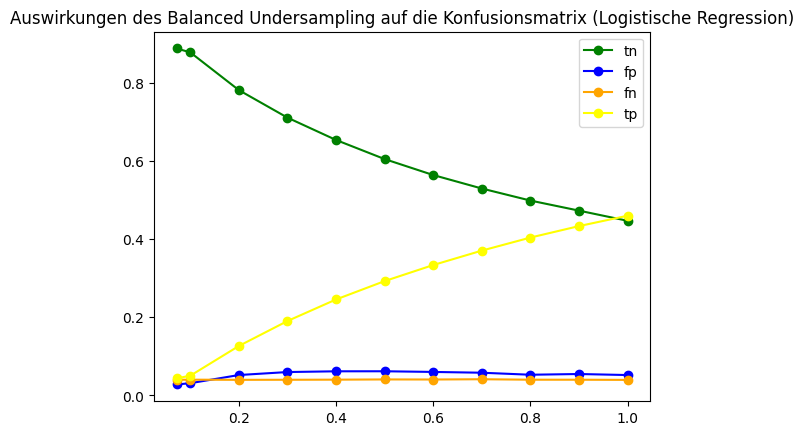

In [7]:
plt.plot(x,tn,color='green',marker='o',label='tn')
plt.plot(x,fp,color='blue',marker='o',label='fp')
plt.plot(x,fn,color='orange',marker='o',label='fn')
plt.plot(x,tp,color='yellow',marker='o',label='tp')
plt.legend()
plt.title('Auswirkungen des Balanced Undersampling auf die Konfusionsmatrix (Logistische Regression)')

Im Diagramm ist Auswirkung des Random Undersamplings auf die einzelnen Bestandteile der Konfusionsmatrix dargestellt. Die x-Achse
gibt jeweils den Quotienten aus Labels der Minoritätenklasse und Labels der Mehrheitsklasse an. Beim Wert x=1 liegen also gleich
viele Datenzeilen von jedem der beiden Labels vor. Während sich der Anteil der falsch Positiven und der falsch Negativen kaum ändert, fällt der Anteil der richtig Positiven auf etwa 50%, während der Anteil der richtig Negativen auf diesen Prozentsatz stark ansteigt. Wir erklären uns dieses Verhalten damit, dass der Klassifikator bei unique-Datenpunkten mit gemischten Labels mit zunehmend stärkerem Undersampling des negativen Labels immer häufiger für "positiv" votiert. 

Text(0.5, 1.0, 'Auswirkungen des Balanced Undersampling auf die Evaluationsmetriken (Logistische Regression)')

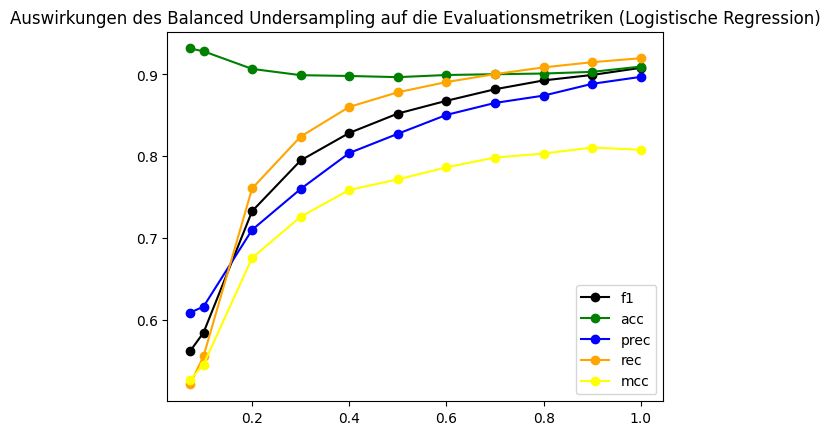

In [8]:
plt.plot(x,f1,color='black',marker='o',label='f1')
plt.plot(x,acc,color='green',marker='o',label='acc')
plt.plot(x,prec,color='blue',marker='o',label='prec')
plt.plot(x,rec,color='orange',marker='o',label='rec')
plt.plot(x,mcc,color='yellow',marker='o',label='mcc')
plt.legend()
plt.title('Auswirkungen des Balanced Undersampling auf die Evaluationsmetriken (Logistische Regression)')

Bis auf die Accuracy steigen alle Evaluationsmetriken bei zunehmendem Undersampling stark an. Die Accuracy fällt am Anfang sehr leicht ab und bleibt dann etwa konstant.  

In [9]:
def oversample(rate):
    train_xu, train_yu = SMOTE(sampling_strategy=rate).fit_resample(train_x, train_y)
    test_xu, test_yu = test_x, test_y
    return train_xu, train_yu, test_xu, test_yu

def apply_1(rate):
    train_xu, train_yu, test_xu, test_yu = oversample(rate)
    acc, f1, prec, rec, mcc,tn,fp,fn,tp = apply_classifier(train_xu, train_yu, test_xu, test_yu, LogisticRegression(max_iter=500))
    return acc, f1, prec, rec, mcc,tn,fp,fn,tp

In [10]:
acc0, f10, prec0, rec0, mcc0,tn0,fp0,fn0,tp0 = apply_classifier(train_x, train_y, test_x, test_y, LogisticRegression(max_iter=500))
x = [0.072]+[0.1*i for i in range(1,11)]
y = [apply_1(i) for i in x[1:]]

f1= [f10]+[y[i][1] for i in range(0,10)]
acc= [acc0]+[y[i][0] for i in range(0,10)]
prec= [prec0]+[y[i][2] for i in range(0,10)]
rec= [rec0]+[y[i][3] for i in range(0,10)]
mcc = [mcc0]+[y[i][4] for i in range(0,10)]
tn= [tn0]+[y[i][5] for i in range(0,10)]
fp= [fp0]+[y[i][6] for i in range(0,10)]
fn= [fn0]+[y[i][7] for i in range(0,10)]
tp = [tp0]+[y[i][8] for i in range(0,10)]


Text(0.5, 1.0, 'Auswirkungen des  Balanced Oversampling auf die Konfusionsmatrix (Logistische Regression)')

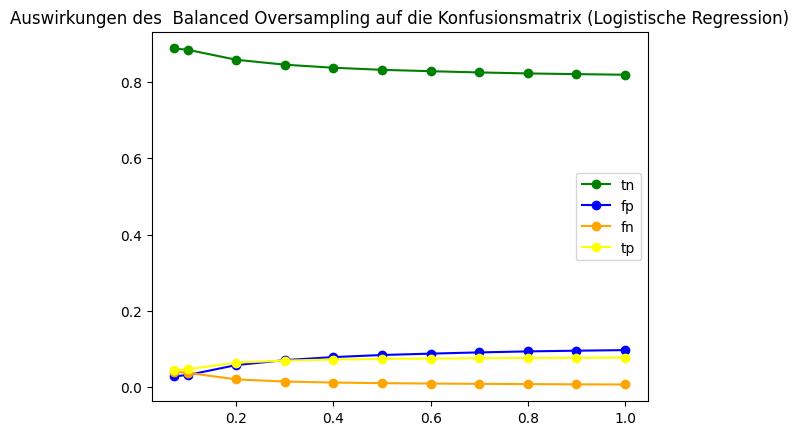

In [11]:
plt.plot(x,tn,color='green',marker='o',label='tn')
plt.plot(x,fp,color='blue',marker='o',label='fp')
plt.plot(x,fn,color='orange',marker='o',label='fn')
plt.plot(x,tp,color='yellow',marker='o',label='tp')
plt.legend()
plt.title('Auswirkungen des  Balanced Oversampling auf die Konfusionsmatrix (Logistische Regression)')

Ein balanciertes SMOTE-Oversampling hat sehr viel weniger Einfluss auf die Bestandteile der Konfusionsmatrix. Dies ist schlüssig, 
weil die synthetisch erzeugten zusätzlichen Daten der Minoritätsklasse in der Regel nicht auf den Kanten bzw. Ecken des hochdimensionalen
Einheitswürfels liegen werden, auf dem unsere Originaldaten liegen. Lediglich in einigen wenigen Fällen werden Datenpunkte auf diesem
Würfel anders (hier: positiv) gelabelt, so dass der Anteil der richtig Negativen leicht abnimmmt und der Anteil der richtig Positven
leicht zunimmt. 

Text(0.5, 1.0, 'Auswirkungen des  Balanced Oversampling auf die Evaluationsmetriken (Logistische Regression)')

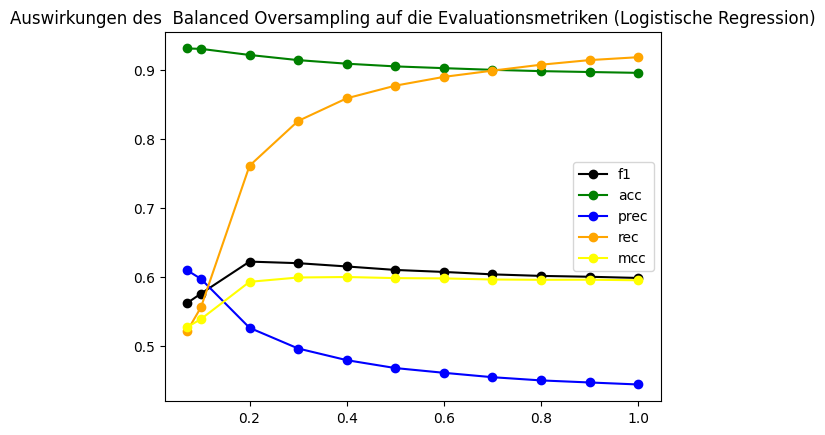

In [13]:
plt.plot(x,f1,color='black',marker='o',label='f1')
plt.plot(x,acc,color='green',marker='o',label='acc')
plt.plot(x,prec,color='blue',marker='o',label='prec')
plt.plot(x,rec,color='orange',marker='o',label='rec')
plt.plot(x,mcc,color='yellow',marker='o',label='mcc')

plt.legend()
plt.title('Auswirkungen des  Balanced Oversampling auf die Evaluationsmetriken (Logistische Regression)')

Die Evaluationsmetriken zeigen einen starken Anstieg des Recalls, einen Abfall der Präzision und etwa gleichbleibende Werte
beim F1-Score (also dem harmonischen Mittel der beiden) und Matthews Korrelationskoeffizient ab einer Oversampling-Rate von 0,2.
Wir erklären dies mit der Annahme, dass Punkte mit gemischten Labels auch beim Oversampling häufiger als positiv klassifiziert werden.
Dadurch, dass die Zeilen mit negativen Labels aber hier nicht (wie beim Undersampling) verschwinden, steigt zwar der Recall, aber
die Präzision sinkt. 

Fazit: Aufgrund der überwiegend booleschen Attribute und der vielen Duplikate mit teilweise gemischten Labels ist unser
Datensatz in seiner Rohversion für einen Klassifikator schwierig. Exakte Klassifikationsgrenzen sind ohne Entmischung der Labels
(für welche zusätzliche Information nötig wäre) nicht zu lernen. 

Wir entscheiden uns für ein Undersampling, welches die Klassifikation dadurch einfacher macht, indem es Information wegnimmt.
Da dadurch aber gleichzeitig der Recall erhöht wird, nehmen wir diesen Informationsverlust, der ja nur bei den Zeilen mit negativem
Label entsteht, in Kauf. Anders ausgedrückt: Es ist in unserem Anwendungsfall sinnvoller, Information über nicht-schwere Verläufe
zu reduzieren und lieber einmal zu viel als einmal zu wenig einen schweren Krankheitsverlauf zu prädizieren.

Möchte man keine Information aufgeben, bestünde eine alternative Möglichkeit darin, die Schwelle der Klassifikatoren anhand
ihrer ROC-Kurve auf den Rohdaten so anzupassen, dass sich ein hinreichend großer Recall ergibt.
        